### Camera Calibration and Distortion Correction

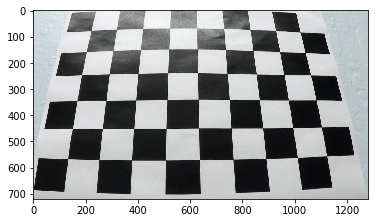

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle


# Read in a calibration image
img = cv2.imread('camera_cal/calibration3.jpg')
plt.imshow(img)

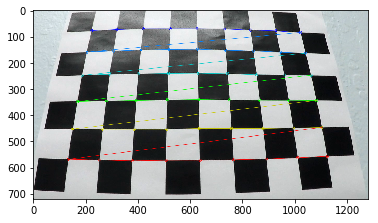

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9 
ny = 6

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


### Run for all images to get objpoints and imgpoints

In [3]:
nx = 9  #num of inside corners in x
ny = 6  #num of inside corners in y
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

### Let us calculate distortion coefficients, and test undistortion on one of the images

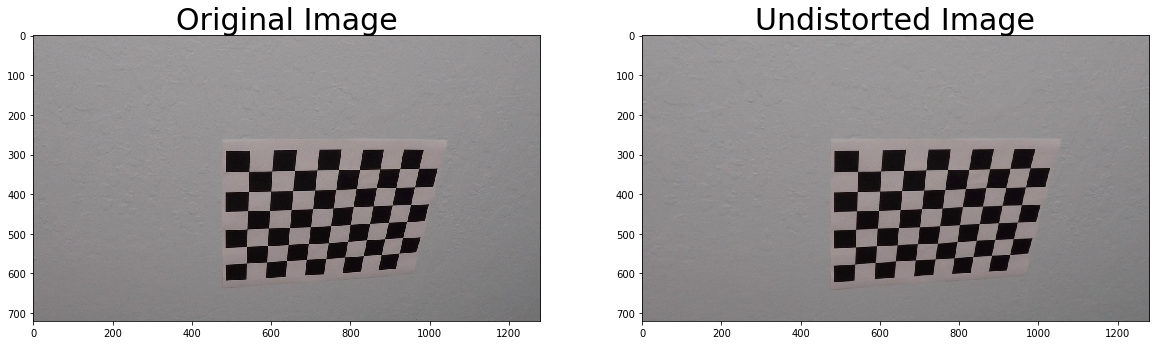

In [4]:
def img_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

# Test undistortion on an image
img_test = cv2.imread('camera_cal/calibration10.jpg')
img_test_size = (img_test.shape[1], img_test.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_test_size,None,None)
dst = img_undistort(img_test, mtx, dist) 

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

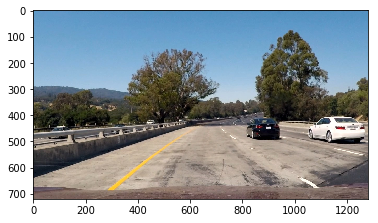

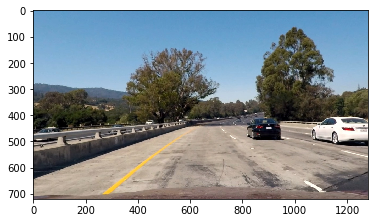

In [5]:
test_img = mpimg.imread('test_images/test1.jpg')

# Display the image                 
plt.imshow(test_img)
plt.show()
test_img_undistort = img_undistort(test_img, mtx, dist)

# Display the image                 
plt.imshow(test_img_undistort)
plt.show()

In [6]:
#Function to check if the grad is within a certain range of threshold
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh=(50, 255)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/ac652b00-7257-4c90-8087-eda8f152a035
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#Function to check if the magnitude of gradient is within a certain threshold range
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=7, mag_thresh=(30, 100)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/78be8208-1af0-4cb4-8a60-2d904b696449
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
# def dir_threshold(img, sobel_kernel=5, thresh=(-np.pi, 1.33)):
def dir_threshold(img, sobel_kernel=7, thresh=(0, np.pi)):
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/d9ad4008-6744-4dc1-803d-e43a67cc050f
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, thresh=(130, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    s_mask = np.zeros_like(s_channel)
    s_mask[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1

    return s_mask

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

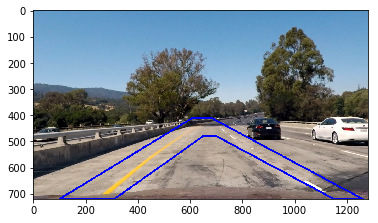

In [7]:
test_img_undistort_overlayed = np.copy(test_img_undistort)

left_bottom = (100, 720)
right_bottom = (1260, 720)
apex1 = (610, 410)
apex2 = (680, 410)
inner_left_bottom = (310, 720)
inner_right_bottom = (1150, 720)
inner_apex1 = (700,480)
inner_apex2 = (650,480)
vertices = np.array([[left_bottom, apex1, apex2, right_bottom, inner_right_bottom, inner_apex1, inner_apex2, inner_left_bottom]], 
                    dtype=np.int32)

region_of_int_overlayed =cv2.polylines(test_img_undistort_overlayed,vertices,True,(0,0,255),5)
plt.imshow(region_of_int_overlayed)
plt.show()

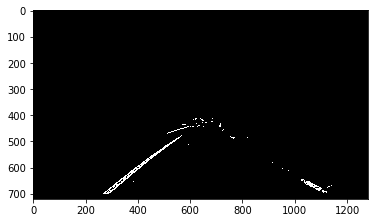

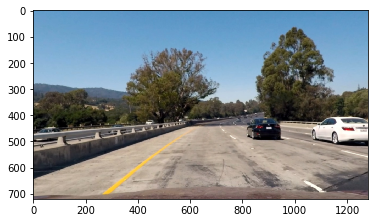

In [8]:
test_img_undistort = gaussian_blur(test_img_undistort)

# Calculate sobel gradient, magnitude and direction
gradx = abs_sobel_thresh(test_img_undistort, orient='x', thresh=(10, 255))
grady = abs_sobel_thresh(test_img_undistort, orient='y', thresh=(60, 255))
mag_binary = mag_thresh(test_img_undistort, mag_thresh=(40, 255))
dir_binary = dir_threshold(test_img_undistort, thresh=(.65, 1.05))
color_binary = color_threshold(test_img_undistort, thresh=(160,255))
# Combine thresholded images
combined = np.zeros_like(dir_binary)

combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined_binary = np.zeros_like(combined)
combined_binary[(color_binary > 0) | (combined > 0)] = 1

# Masked area
combined = region_of_interest(combined_binary, vertices)

plt.imshow(combined, cmap="gray")
plt.show()
plt.imshow(test_img_undistort)
plt.show()

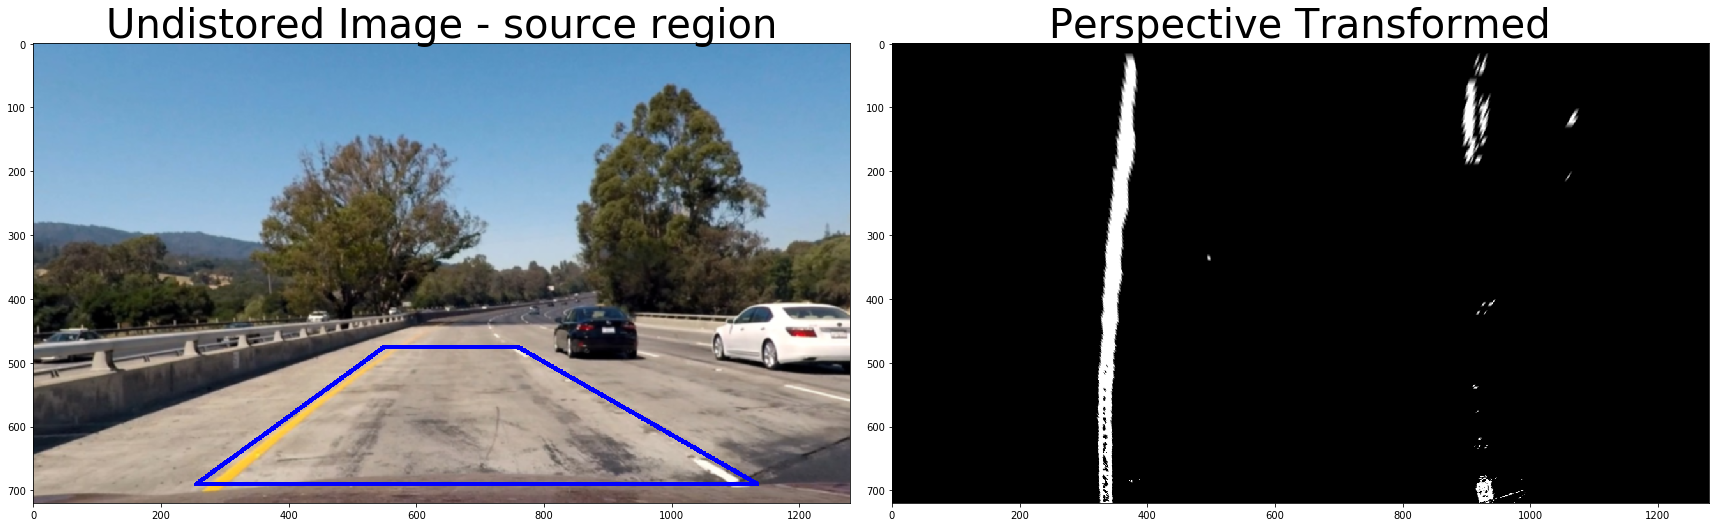

In [9]:
img_shape = (combined.shape[1], combined.shape[0])

# define 4 source points for perspective transformation
src = np.float32([[255, 690], [550, 475], [759, 475], [1135, 690]])
# define 4 destination points for perspective transformation
dst = np.float32([[310, img_shape[1]], [310, 0], [950, 0], [950, img_shape[1]]])  
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_image = cv2.warpPerspective(combined, M, img_shape)
combined_copy = np.copy(test_img_undistort)
# pts = np.array([[220,719],[1130,719],[755,477],[580,478]], np.int32)
# pts = np.array([[0,720],[1280,720],[800,480],[480,480]], np.int32)
# pts = np.array([[293, 668], [587, 458], [703, 458], [1028, 668]], np.int32)
pts = np.array([[255, 690], [550, 475], [759, 475], [1135, 690]], np.int32)
pts = pts.reshape((-1,1,2))

undist_redlines =cv2.polylines(combined_copy,[pts],True,(0,0,255),5)
#, figsize=(24,9)
#, fontsize = 40
# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(combined_copy, cmap="gray")
ax1.set_title('Undistored Image - source region', fontsize = 40)
ax2.imshow(warped_image, cmap="gray")
ax2.set_title('Perspective Transformed', fontsize = 40)


In [10]:
warped_image_gb = cv2.GaussianBlur(warped_image,(5,5),0)

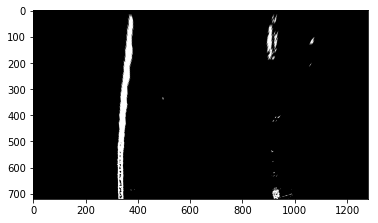

In [11]:
plt.imshow(warped_image_gb, cmap="gray")

In [12]:
binary_warped = warped_image_gb
plotit = True

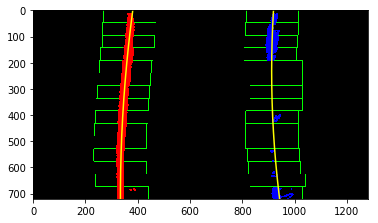

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 15
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[
                    0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty**2 + \
    right_fit[1] * ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[
    left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[
    right_lane_inds]] = [0, 0, 255]

if plotit:
    plt.imshow(out_img / 255)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

fit_vals = (leftx, lefty, rightx, righty, ploty)

In [14]:
global left_fit_g, right_fit_g, curvature_g
left_fit_g, right_fit_g, curvature_g = [], [], []

In [15]:
def smooth_fits(left_fit, right_fit, n=20):
    """
    Smoothes the polynomial fits
    Inputs:
    - left, right fit : Polynomial fit of current frame
    """
    left_fit_g.append(left_fit)
    right_fit_g.append(right_fit)

    left_fit_np = np.array(left_fit_g)
    right_fit_np = np.array(right_fit_g)

    if len(left_fit_g) > n:
        left_fit = np.mean(left_fit_np[-n:, :], axis=0)
    if len(right_fit_g) > n:
        right_fit = np.mean(right_fit_np[-n:, :], axis=0)
    return left_fit, right_fit

In [16]:
left_fit, right_fit = smooth_fits(left_fit, right_fit)

 ### Calculate curvature

In [17]:
def calculate_curvature(img, left_fit, right_fit, fits):
    """
    Calculates curvature for given polynomial fits
    Returns:
    - left_curverad, right_curverad : Radius of curvature in meters
    """
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = img.shape[0]
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fits[1] * ym_per_pix, fits[0] * xm_per_pix, 2)
    right_fit_cr = np.polyfit(fits[3] * ym_per_pix, fits[2] * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[
                     1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                      1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Offset from center
    x_offset = ((left_fit_cr[2] + right_fit_cr[2]) / 2) - (img.shape[1]*xm_per_pix/2)

    return left_curverad, right_curverad, x_offset

In [18]:
curvature_in_m,_,offset_from_center = calculate_curvature(combined, left_fit, right_fit, fit_vals)

In [19]:
def warp_perspective_back(warped, undist, left_fit, right_fit, fits, Minv):
    """
    Warps perspective back to original view and draws lane area
    Inputs:
    - img : Undistorted and perspective transformed image
    """
    # Create an image to draw the lines on
#     color_warp = np.zeros_like(warped).astype(np.uint8)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_fit[0] * fits[4]**2 + left_fit[1] * fits[4] + left_fit[2]
    right_fitx = right_fit[0] * fits[4]**2 + right_fit[1] * fits[4] + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, fits[4]]))])
    pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx, fits[4]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective
    # matrix (Minv)
    newwarp = cv2.warpPerspective(
        color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [20]:
def smooth_curvature(curvature, n=50):
    """
    Smoothes the curvature over n frames
    """
    curvature_g.append(curvature)
    curvature_np = np.array(curvature_g)

    if len(curvature_g) > n:
        curvature = np.mean(curvature_np[-n:])

    return curvature

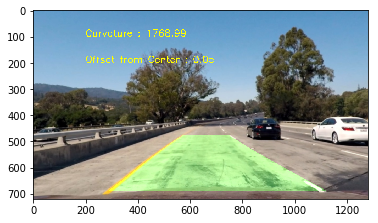

In [21]:
result = warp_perspective_back(warped_image_gb, test_img_undistort, left_fit, right_fit, fit_vals, Minv=Minv)
# Add curvature to image
curvature_in_m = np.mean(curvature_in_m)
curvature_in_m = smooth_curvature(curvature_in_m)
curvature_text = 'Curvature : {:.2f}'.format(curvature_in_m)
offset_text = 'Offset from Center : {:.2f}'.format(offset_from_center)
cv2.putText(result, curvature_text, (200, 100), 0, 1.2, (255, 255, 0), 2)
cv2.putText(result, offset_text, (200, 200), 0, 1.2, (255, 255, 0), 2)
plt.imshow(result)